# Supervised Learning Workflow

## Machine learning for discovery of MOFs for gas separation applications

In this notebook we will build machine learning models that can predict the gas uptake (carbon dioxide and methane) of metal-organic frameworks (MOFs), which are crystalline materials consisting of inorganic metal nodes linked by organic linkers. The discovery of MOFs for carbon capture is needed for emission reduction technologies, as these materials can efficiently adsorb and store greenhouse gases like CO$_2$. Machine learning accelerates this discovery process by enabling the prediction of gas uptake properties from structural and chemical descriptors, reducing the need for time-consuming and costly experiments or simulations.

![MOF building principle](../assets/mof_building_principle.png)

There are two main **learning goals** for our tutorial: 

1. Understand the typical workflow for machine learning in chemistry and materials. We will cover exploratory data analysis (EDA) and supervised learning (KRR).

2. Get familiar with some Python packages that are useful for data analysis and visualization. 

At the end of the exercise, you will produce plot like the one below, comparing the predictions of your model against computed values from GCMC simulations.
The histograms show the distributions of the errors on the training set (left) and on the test set (right).



<img src="../assets/result.gif" alt="Parity interactive" width="700"/>

We will be using scikit-learn for modeling. The [sklearn documentation](https://scikit-learn.org/stable/user_guide.html) is a great source of reference with many explanations and examples. Also, we use Pandas dataframe (df) for data manipulation. You can select columns using their name by running `df[columnname]`. If at any point you think that the dataset is too large for your computer, you can select a subset using `df.sample()` or by making the test set larger in the train/test split (section 2). 

As descriptors we will use pore geometric descriptors, such as density, pore volume, etc. and [revised autocorrelation functions](https://www.nature.com/articles/s41467-020-17755-8) (RACs) for describing chemistry of MOFs. Our dataset has four properties for MOFs:
- CO2 uptake at 0.15 bar and 298K
- CO2 uptake at 16 bar and 298K
- CH4 uptake at 5.8 bar and 298K
- CH4 uptake at 65 bar and 298K


Let's start with a simple one that is the high-pressure CO$_2$ uptake `df["CO2 uptake at 16 bar and 298K"]`. This is the amount of CO$_2$ (mmol) the MOF can load per gram.

Below, we define three global variables (hence upper case), which are the *names* of our feature and target columns. We will use the `TARGET` for the actual regression and the `TARGET_BINARY` only for the stratified train/test split. The `FEATURES` variable is a list of column names of our dataframe. We imported the names of descriptors from `MOF_descriptors.py`.

In [1]:
# name of descriptors
from MOF_descriptors import geometric_descriptors, linker_descriptors, metalcenter_descriptors, functionalgroup_descriptors, summed_linker_descriptors, summed_metalcenter_descriptors, summed_functionalgroup_descriptors

TARGET = "CO2 uptake at 16 bar and 298K"
FEATURES = (
    geometric_descriptors
    + summed_functionalgroup_descriptors
    + summed_linker_descriptors
    + summed_metalcenter_descriptors
)

Examples for pore geometry descriptors (in `geometric_descriptors`) include: $D_i$ (the size of the largest included sphere), $D_f$ (the largest free sphere), and $D_{if}$ (the largest included free sphere) along the pore $-$ three ways of characterizing pore size. 

![pore diameters](../assets/spheres.png)

Also included are the surface area (SA) of the pore, and the probe-occupiable pore volume (POV).
More details on the description of pore geometries can be found in [Ongari et al.](https://pubs.acs.org/doi/abs/10.1021/acs.langmuir.7b01682)

RACs (in the lists starting with `summed_...`) operate on the structure graph and encode information about the metal center, linkers and the functional groups as differences or products of heuristics that are relevant for inorganic chemistry, such as electronegativity ($\chi$), connectivity ($T$), identity ($I$), covalent radii ($S$), and nuclear charge ($Z$).


<img src="../assets/racs.png" alt="RACs scheme from the lecture" width="700"/>

The number in the descriptornames shows the coordination shell that was considered in the calculation of the RACs.

> **Credit:** This notebook is adapted from our (Mohamad Moosavi and Kevin Jablonka) lecture and hands-on session in MolSim winter school in Amsterdam. 
> - [MolSim](https://www.compchem.nl/molsim/) course website.
> - [kjappelbaum/ml_molsim](https://github.com/kjappelbaum/ml_molsim) on GitHub.

## 0. Setup programming environment 

## 0.1 Installing packages

### Only if you run this notebook on Colab

If you use this notebook on Colab, please uncomment the lines below (remove the `#`) and execute the cell.

In [2]:
#import sys
#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension
#!pip install --upgrade pandas sklearn holoviews bokeh plotly matplotlib
#!wget https://raw.githubusercontent.com/kjappelbaum/ml_molsim/2022/descriptornames.py
#!mkdir data
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/data.csv
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/features.csv
# import os, holoviews as hv
# os.environ['HV_DOC_HTML'] = 'true'

## 0.2 Import packages we will need

In [3]:
# basics
import os
import numpy as np
import pprint as pp

# pandas is used to read/process data
import pandas as pd
from ydata_profiling import ProfileReport

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# train/test split
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression, SGDRegressor
# pipeline to streamline modeling pipelines
from sklearn.pipeline import Pipeline
# principal component analysis
from sklearn.decomposition import PCA
# polynomial kernel
from sklearn.metrics.pairwise import polynomial_kernel
# Dummy model as baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
# Variance Threshold for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# metrics to measure model performance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error)

# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import check_scoring
from sklearn.utils import Bunch
from sklearn.utils import check_random_state
from sklearn.utils import check_array

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from pymatviz.parity import hist_density

/Users/moosavi/anaconda3/envs/che1147/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/moosavi/anaconda3/envs/che1147/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


## 0.3 Fix the random seed

In [4]:
# add code here

RANDOM_SEED = 1147
np.random.seed(RANDOM_SEED)

 $\color{DarkBlue}{\textsf{Short question}}$
- We declared a global variable to fix the random seed (`RANDOM_SEED`). Why did we do this?  

## 0.4 Import the data

The dataset used in this tutorial originates from the publication ["Understanding the diversity of the metal-organic framework ecosystem"](https://doi.org/10.1038/s41467-020-17755-8), which explores the application of machine learning for predicting gas adsorption properties in MOFs. This dataset contains geometric and chemical descriptors, as well as simulated gas uptake values, enabling the development and evaluation of regression models for materials discovery.

In [5]:
DATA_DIR = '../data'
DATA_FILE = os.path.join(DATA_DIR, 'MOF_CoRE2019.csv')
df = pd.read_csv(DATA_FILE)

Let's take a look at the first few rows to see if everythings seems reasonable ...

In [6]:
df.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-2,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K
0,XAGCUE_clean,0.00,2.87682,6.41175,6.41175,487.410,0.000000,0.0000,0.101882,0.21558,...,10752.0,10752.0,242.0856,523.7232,844.9008,1049.6448,1.266370,3.120211,1.810078,2.173372
1,SOBZEQ_clean,2298.52,5.44324,7.06044,7.04565,0.000,0.738273,0.6363,0.000000,0.00000,...,2240.0,2544.0,58.2840,130.2840,194.2144,231.0000,8.224130,17.486748,4.560643,11.578465
2,AVAQIX01_clean,0.00,3.61603,5.36267,5.34980,600.353,0.000000,0.0000,0.226377,0.30062,...,3040.0,2688.0,91.7328,204.2656,276.2848,265.7760,3.694178,5.849020,3.859973,5.251466
3,INURIS_clean,0.00,3.09799,5.07769,4.57779,253.440,0.000000,0.0000,0.077296,0.09856,...,12720.0,13728.0,301.4544,713.6976,1037.0160,1127.9280,1.007227,4.092395,2.032925,3.728986
4,KEDNOY_clean,0.00,3.63243,4.98967,4.98020,519.714,0.000000,0.0000,0.238159,0.28890,...,2064.0,1920.0,72.0852,153.0144,199.7088,218.5200,3.617103,6.170669,3.924974,4.888655


<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>Use something like <code>pd.options.display.max_columns=100</code> to adjust how many columns are shown.<code>pd.options.display.max_columns=100</code>  would show at maximum 100 columns. </li>
</ul>
</details>

Let's also get some basic information ...

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Columns: 331 entries, MOFname to CH4 uptake at 65 bar and 298K
dtypes: float64(330), object(1)
memory usage: 12.7+ MB


 $\color{DarkBlue}{\textsf{Short question}}$
- How many materials are in the dataset? 
- Which datatypes do we deal with?

### 0.4 Basic Data Cleaning and Preparation

We perform some data cleaning by removing instances with missing value and removing duplicates.

 $\color{DarkBlue}{\textsf{Short question}}$
- Should we remove columns or rows with missing value?

In [8]:
num_rows_with_nan = df.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {num_rows_with_nan}")

Number of rows with NaN values: 0


In [9]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Columns: 331 entries, MOFname to CH4 uptake at 65 bar and 298K
dtypes: float64(330), object(1)
memory usage: 12.7+ MB


We remove duplicate rows, ensuring dataset contains only unique samples.

In [10]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 5013
Columns: 331 entries, MOFname to CH4 uptake at 65 bar and 298K
dtypes: float64(330), object(1)
memory usage: 12.7+ MB


 $\color{DarkBlue}{\textsf{Short question}}$
- How many duplicated entries did we remove?

## 1. Split the data

As the first step, we split our data into a training set and a test set. In order to prevent *any* information of the test set from leaking into our model, we split *before* starting to analyze or transform our data.
> **Note:** Not doing the split at this stage can cause data leakage.

## 1.1 Random splitting

A common way of splitting data is random splitting. We can use `sklearn's train_test_split` for doing this. 

Depending on the size of the dataset, we might have different splitting ratio. Common split rations are:
- **80/20 Split**: 80% for training, 20% for testing.
- **Train/Validation/Test Split**: For larger datasets, a common split is 70% training, 15% validation, and 15% testing.

In [11]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,  # 20% for testing
    random_state=RANDOM_SEED  # Ensure reproducibility
)

### 1.1. Split with stratification

Random splitting may lead to imbalanced class distributions between training and test sets, which can result in biased model evaluation and poor generalization. 
[Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) ensures that the class distributions (ratio of "good" to "bad" materials) are the same in the training and test set.

 $\color{DarkBlue}{\textsf{Short question}}$

- Why is this important? What could happen if we would not do this? 

For stratification to work, we to define what makes a "good" or a "bad" material. This requires knowing the target property of interest. Let's start with developing a model for a simple target, which is CO2 uptake at room temperature and high pressure (16bar).

 $\color{DarkBlue}{\textsf{Short question}}$
- How can we choose a good value to for classifying "good" and "bad" materials?  

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    You can choose it based on the histogram of the property of interest.
</ul>
</details>

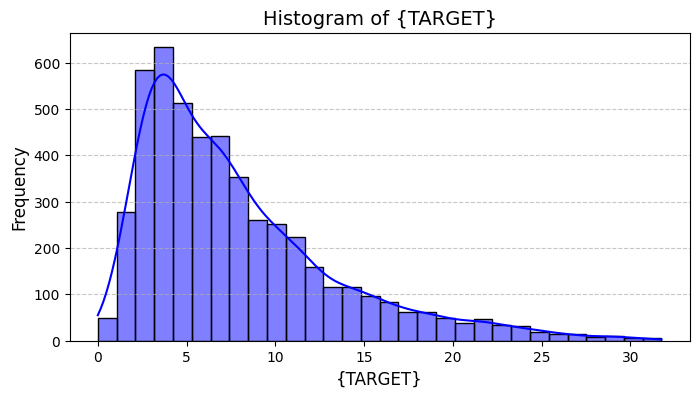

In [12]:
# add code here
# Plot histogram of the target
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET], kde=True, bins=30, color='blue')

# Add labels and title
plt.xlabel("{TARGET}", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of {TARGET}", fontsize=14)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on this histogram and the tail of the distribution, we will use 15 mmol CO$_2$ / g as the threshold for the uptake, thus binarizing our continuous target variable. We use this threshold to define a new column with binary values of 0 and 1 for bad and good materials. 

 $\color{DarkBlue}{\textsf{Short Exercise}}$
 - add a column 'target_binary' that encodes whether a material is low performing (`0`) or high perfoming (`1`) by comparing the uptake with the `THRESHOLD`

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> you can use <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html'>pd.cut</a>, 
    <a href='https://stackoverflow.com/questions/4406389/if-else-in-a-list-comprehension'>list comprehension</a>, the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer'> binarizer in sklearn </a>...) </li>
    <li> a list comprehension example: <code> [1 if value > THRESHOLD else 0 for value in df[TARGET]] </code> </li>
</ul>
</details>

In [13]:
TARGET_BINARY = "target_binned" # name of the new binary target column
THRESHOLD = df[TARGET].quantile(0.85)  # Top 15% of the dataset
df[TARGET_BINARY] = (df[TARGET] > THRESHOLD).astype(int)

Now, we can perform the actual split into training and test set using stratified sampling. 

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- select reasonable values for `XX` and `XY` and then perform the test/train splits. What do you consider when making this decision (think about what you would do with really small and really big datasets, what happens if you have only one test point, what happens to the model performance if you have more test points than training points)? 
- why do we need to perform the split into a training and test set? 
- would we use the test set to tune the hyperparameters of our model?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>The `size` arguments can either be integers or, often more convenient, decimals like 0.1</li>
    <li>When you perform the split into training and test set you need to trade-off bias (pessimistic bias due to little training data) and variance (due to little test data) </li>
    <li>A typical split cloud be 70/30, but for huge dataset the test set might be too big and for small datasets the training set might be too small in this way </li>
</ul>
</details>

In [14]:
# add code here
XX = 0.1  # 10% for training -- ONLY for development stage
YY = 0.1  # 10% for testing -- ONLY for development stage

In [15]:
df_train_stratified, df_test_stratified = train_test_split(
    df,
    train_size=XX,
    test_size=YY,
    random_state=RANDOM_SEED,
    stratify=df[TARGET_BINARY],
)

Check if splitting is reasonable:

In [16]:
df_train_stratified.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K,target_binned
1480,RAVFAX_clean,0.00,3.18180,4.34195,4.31956,90.344,0.000000,0.00000,0.054221,0.09316,...,5728.0,123.5016,279.1712,418.3392,498.4672,2.472788,3.520404,1.903463,2.712515,0
1626,LAZLEF_clean,0.00,3.28934,4.78618,3.84091,416.919,0.000000,0.00000,0.095960,0.14504,...,4380.0,103.0470,242.6706,338.7756,348.1230,0.836475,2.665640,1.701422,2.501237,0
4782,JUJMOS_clean,0.00,3.46125,10.00436,8.09560,1192.150,0.000000,0.00000,0.367516,0.36900,...,7872.0,157.1220,369.9696,544.5816,637.0560,1.480343,10.297658,3.532900,7.305281,0
3773,NUVXUZ_clean,1780.87,9.67380,23.89274,23.87635,0.000,1.642900,0.82192,0.000000,0.00000,...,1920.0,141.6480,274.7088,329.7888,244.7040,0.107633,13.383918,1.375064,11.920172,1
2429,VIXCUB_clean,1916.27,4.89154,5.48718,5.42033,0.000,0.470576,0.51510,0.000000,0.00000,...,2128.0,59.8528,139.5856,203.3056,208.3168,2.320571,9.706703,2.650257,6.918807,0


In [17]:
df_test_stratified.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K,target_binned
238,ja907023c_si_004_clean,1626.16,5.45923,9.71961,9.49261,314.77400,0.761495,0.50702,0.172959,0.11516,...,4944.0,110.5800,264.4872,388.8480,427.5504,0.536307,18.201152,5.802834,15.279534,1
4432,UMOVEZ02_clean,2802.38,5.70160,10.40783,10.05852,0.00000,1.302740,0.72206,0.000000,0.00000,...,5736.0,101.3706,244.9986,371.0772,456.1896,0.464408,23.073399,5.763149,18.614999,1
1786,DARSEV_SL,1602.21,7.15114,9.02256,9.02256,0.00000,0.541932,0.49726,0.000000,0.00000,...,4272.0,73.2066,177.7386,274.3428,340.0908,0.758465,10.852674,3.479558,8.548291,0
2294,VUKSAX_clean,1761.31,9.42624,10.78924,10.78325,0.00000,0.973032,0.64670,0.000000,0.00000,...,2836.0,52.9216,127.9740,197.6120,223.3612,0.261169,16.881153,4.011592,13.747812,1
4210,QUPZIK_clean,0.00,2.41479,3.88028,3.87702,5.42934,0.000000,0.00000,0.000000,0.00000,...,912.0,54.7552,111.3728,147.1520,137.3936,1.762770,2.573701,0.275007,1.359189,0


## 2. Exploratory data analysis (EDA) 

After we have put the test set aside, we can give the training set a closer look.

## 2.1 ydata profiling

> this part takes long so let's do it at home!

In [18]:
# profile = ProfileReport(df_train_stratified, title="EDA Report", explorative=True)

In [19]:
# profile.to_notebook_iframe()

In [20]:
# Save to an html file
# profile.to_file("MOF_eda_report.html")

### 2.2 Removing redundant columns

We remove any feature that does not have variance across the dataset to reduce dimensionality. 

In [21]:
# Initialize VarianceThreshold with a threshold 0.0
selector = VarianceThreshold(threshold=0.0)

# Fit the selector on the training data
selector.fit(df_train_stratified[FEATURES])

# Get the selected features
redundant_features = [FEATURES[i] for i in range(len(FEATURES)) if selector.variances_[i] == 0.0]
df[redundant_features]

,sum-D_func-chi-0-all,sum-D_func-Z-0-all,sum-D_func-I-0-all,sum-D_func-I-1-all,sum-D_func-I-2-all,sum-D_func-I-3-all,sum-D_func-T-0-all,sum-D_func-S-0-all,sum-D_func-alpha-0-all,sum-D_lc-chi-0-all,...,sum-D_lc-S-0-all,sum-D_lc-alpha-0-all,sum-D_mc_CRY-chi-0-all,sum-D_mc_CRY-Z-0-all,sum-D_mc_CRY-I-0-all,sum-D_mc_CRY-I-1-all,sum-D_mc_CRY-I-2-all,sum-D_mc_CRY-I-3-all,sum-D_mc_CRY-T-0-all,sum-D_mc_CRY-S-0-all
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# update feature set
print(f"Number of features before: {len(FEATURES)}")
FEATURES = [feature for feature in FEATURES if not feature in redundant_features]
print(f"Number of features after: {len(FEATURES)}")

Number of features before: 164
Number of features after: 138


### 2.3. Correlations

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Plot some features against the target property and calculate the Pearson and Spearman correlation coefficient (what is the different between those correlation coefficients?) 
- What are the strongest correlations? Did you expect them? 
- What can be a problem when features are correlated?
- *Optional:* Do they change if you switch from CO$_2$ uptake at high pressure to low pressure `CO2 uptake at 0.15 bar and 298K`?  Explain your observation.

To get the correlation matrices, you can use the `df.corr(method=)`method on your dataframe (`df`). You might want to calculate not the full correlation matrix but just the correlation of the features with the targets

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> To get the correlation with a target, you can use indexing. E.g. <code>df.corr(method='spearman')[TARGET]</code></li>
    <li> use <code>.sort_values()</code> method on the output of `df.corr()` to sort by the value of the correlation coefficient  </li>
    <li> Scatter plot of TARGET vs. one descriptor (e.g., Density) </li>
</ul>
</details>

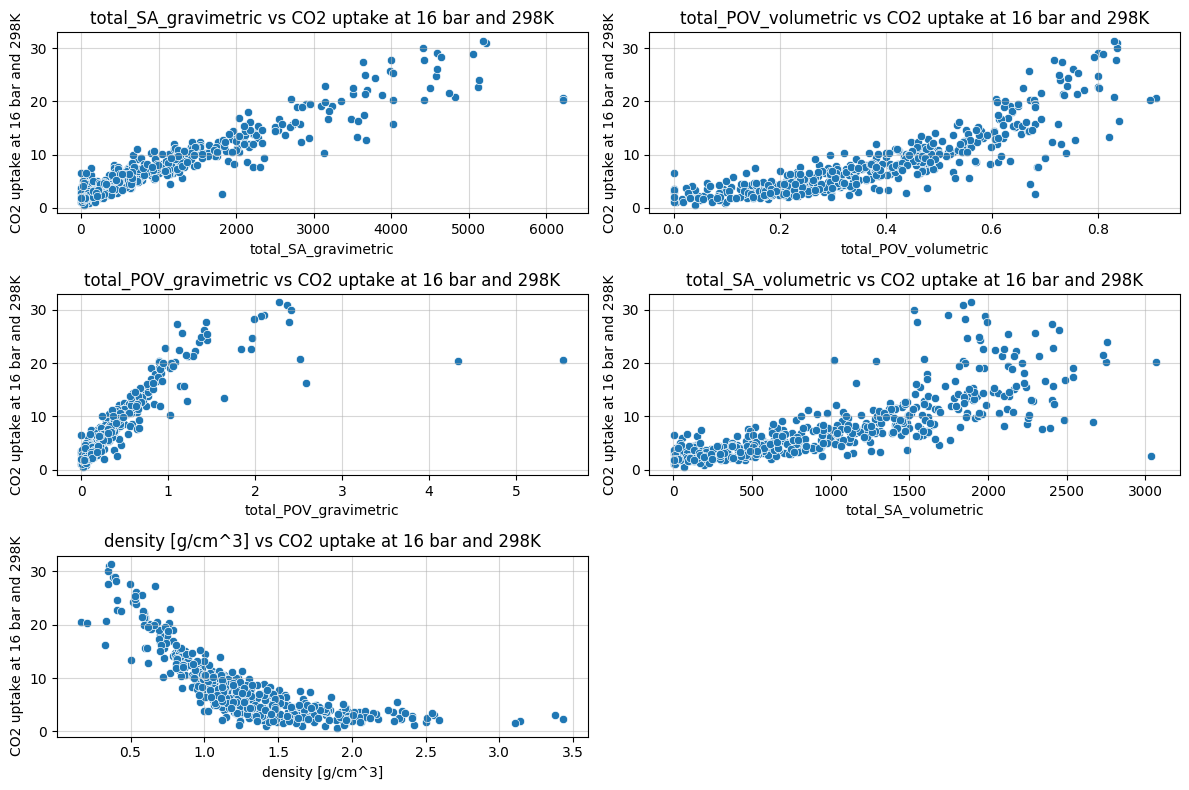

In [23]:
# add code here
# Calculate the correlation of all features with the target
correlations = df_train_stratified[FEATURES+[TARGET]].corr(method='pearson')[TARGET]

# Get the top 5 features with the highest absolute correlation to the target
top_5_features = correlations.abs().sort_values(ascending=False).iloc[1:6].index

# Plot the correlation of these features with the target
plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_5_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=df_train_stratified[feature], y=df_train_stratified[TARGET])
    plt.title(f"{feature} vs {TARGET}")
    plt.xlabel(feature)
    plt.ylabel(TARGET)
    plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

## 3. Baselines

For machine learning, it is important to have some *baselines* to which one then compares the results of a model. Think of a classification model for some rare disease where we only have 1% postives. A classification model that only predictes the negatives *all the time* will still have a amazingly high accuracy. To be able to understand if our model is really better than such a simple prediction we need to make the simple prediction first. This is what we call a baseline.

A baseline could be a really simple model, a basic heuristic or the current state of the art (SOTA).
this. We will use a heuristic but if you aim for a publication, a baseline for you will be the state of the art model.

For this we use sklearn `Dummy` objects that simply calculate the mean, the median or the most frequent case of the training set, when you run the `fit()` method on them (which takes the features matrix $\mathbf{X}$ and the labels $\mathbf{y}$ as arguments.
This is, the prediction of a `DummyRegressor` with `mean` strategy will always be the mean, independent of the input (it will not look at the feature matrix!). 

Instead of using those `sklearn` objects you could also just manually compute the the mean or median of the dataset. But we will use those objects as we can learn in this way how to use estimators in `sklearn` and it is also allows you to test your full pipeline with different (baseline) models. 
What does this mean? In practice this means that you can use all the regression and classification models shown in the figure below in the same way, they will all have a `fit()` method that accepts `X` and `y` and a predict method that accepts `X` and returns the predictions. 


<img src="https://scikit-learn.org/1.3/_static/ml_map.png" alt="ML Map" width="800"/>

The estimator objects can be always used in the same way 

<img src="https://static.packt-cdn.com/products/9781789800265/graphics/d49a2e95-8f22-42ed-89f1-474b3d028787.png" alt="ML Map" width="400"/>

Using these objects, instead of the mean directly, allows you to easily swap them with other models in pipelines, where one chains many data transformation steps (see section 6).

### 3.1. Build dummy models

$\color{DarkBlue}{\textsf{Short Question}}$
- If you call `.fit(X, y)` on a `DummyRegressor` does it actually use the `X`? If not, why is there still the place for the `X` in the function? If yes, how does it use it?

$\color{DarkBlue}{\textsf{Short Exercise}}$
- Create [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) instances for  `mean`, `median`. (e.g. `dummyinstance = DummyRegressor(strategy='mean')`)
- Train them on the training data (`dummyinstance.fit(df_train[FEATURES], df_train[TARGET])`)

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to create <code>DummyRegressor</code> you can for example use <code> dummyregressor_mean = DummyRegressor(strategy='mean') </code> </li>
    <li> to see the implementation of the <code>DummyRegressor</code> you can check out <a href="https://github.com/scikit-learn/scikit-learn/blob/73732e5a0bc9b72c7049dc699d69aaedbb70ef0a/sklearn/dummy.py#L391"> the source code on GitHub</a> </li>
</ul>
</details>

In [24]:
# your code here
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor(strategy='median') #fillme

In [25]:
# Fit Dummy Regressors
dummyregressor_mean.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
dummyregressor_median.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET]) #fillme

,strategy,'median'
,constant,None
,quantile,None


#### Evaluate the performance of the dummy models

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Calculate maximum error, mean absolute error and mean square error for the dummy regressors on training and test set. What would you expect those numbers to be?
- Do the actual values surprise you? 
- What does this mean in practice for reporting of metrics/the reasoning behind using baseline models

It can be handy to store our metrics of choice in a nested dictionary ([Python dictionaries are key-value pairs](https://www.tutorialspoint.com/python/python_dictionary.htm)): 

```python
{
    'dummyestimator1': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
    'dummyestimator2': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
 }
``` 

You will now write functions `get_regression_metrics(model, X, y_true)` that compute the metrics and return this dictionary for a given model. The `predict` method takes the feature matrix $\mathbf{X}$ as input.

In them, we calculate 

$\mathrm {MAE} =\frac{\sum _{i=1}^{n}\left|Y_{i}-\hat{y}_{i}\right|}{n}.$

,

$\mathrm {MSE} = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.$ 

$\mathrm{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{Y_i - \hat{Y}_i}{max (\epsilon,Y_i)} \right|$

where $\hat{y}$ are the predictions and, $Y_{i}$ the true values.

We also include maximum error which is a good indication for generalization in many cases. 

See more information on [sklearn's Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error)



<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to perform a prediction using a estimator object, you can call <code> classifier.predict(X) </code> </li>
    <li> to calculate metrics, you can for example call <code>accuracy_score(true_values, predicted_values) </code> </li>
</ul>
</details>

In [26]:
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = model.predict(X) #fillme)

    mae = mean_absolute_error(y_predicted,y_true) #fillme)
    mse = mean_squared_error(y_predicted,y_true) #fillme)
    maximum_error = max_error(y_predicted,y_true) #fillme)
    mape = mean_absolute_percentage_error(y_predicted,y_true) #fillme)

    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error,
        'mape': mape
    }

    return metrics_dict

In [27]:
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [28]:
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, df_test[FEATURES], df_test[TARGET])
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, df_train[FEATURES], df_train[TARGET])

Calculating metrics for mean
Calculating metrics for median


In [29]:
print("Dummy Regressor Results - Train & Test Set")

for regressorname, metrics in dummy_regressor_results_train.items():
    print(f"{regressorname} (Train): {metrics}")
    
for regressorname, metrics in dummy_regressor_results_test.items():
    print(f"{regressorname} (Test): {metrics}")


Dummy Regressor Results - Train & Test Set
mean (Train): {'mae': 4.259409876186213, 'mse': 30.220709883558435, 'max_error': 23.7344978415598, 'mape': 0.5307932750651863}
median (Train): {'mae': 4.058294077632125, 'mse': 32.15902419117929, 'max_error': 25.2486677507, 'mape': 0.6233515736350359}
mean (Test): {'mae': 4.429003548283983, 'mse': 32.292770699277106, 'max_error': 23.3019541480598, 'mape': 0.5519274657770011}
median (Test): {'mae': 4.118487287334601, 'mse': 33.24735897287667, 'max_error': 24.8161240572, 'mape': 0.6325972150972914}


## 4. Building a linear regression model

In practice, we often rely on optimized libraries such as **scikit-learn** for machine learning models.  
They are fast, robust, and widely used.  

However, to really understand *what happens under the hood*, it is useful to **implement a simple linear regression model ourselves**.  

### Goals for this section:
- Implement **gradient descent** for linear regression.
- Compare results between **gradient descent** and the **closed-form (normal equation)** solution.
- Use **scikit-learn**'s `LinearRegression` as a baseline for comparison.


### 4.1 sklearn linear regression

Let's first use the sklearn model to get a good baseline for comparison. 
You can see with few lines below, we can train a machine learning model. 
The code is very flexible and you can essentially replace the linear regression with other models in sklearn. 

In [30]:
# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

# Evaluate the model on the training and test sets
linear_regressor_results_train = get_regression_metrics(
    linear_regressor, df_train_stratified[FEATURES], df_train_stratified[TARGET]
)
linear_regressor_results_test = get_regression_metrics(
    linear_regressor, df_test_stratified[FEATURES], df_test_stratified[TARGET]
)

# Print the results
print("Linear Regression Results - Train Set:", linear_regressor_results_train)
print("Linear Regression Results - Test Set:", linear_regressor_results_test)

Linear Regression Results - Train Set: {'mae': 0.8726453446922848, 'mse': 1.5135684940662255, 'max_error': 6.734279686948421, 'mape': 0.16816589357532818}
Linear Regression Results - Test Set: {'mae': 1.763475008678401, 'mse': 30.245066990748892, 'max_error': 97.27262849232599, 'mape': 0.36415279837967135}


### 4.1 Linear regression from scratch

Now, let's code a linear regression to see if we understand all parts. Specifically, we are going to code the gradient descent for our regressor to fit its parameters. 

The class below supports:
- `method="normal"`: closed-form solution using the normal equation  
- `method="gd"`: gradient descent with configurable learning rate and iterations  
- Optional standardization of features for smoother optimization  


In [31]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True, standardize=False, method="normal",
                 lr=1e-2, n_iters=100, tol=1e-8, random_state=0):
        """
        method: "normal" (closed-form) or "gd" (gradient descent, MSE loss)
        """
        self.fit_intercept = fit_intercept
        self.standardize = standardize
        self.method = method
        self.lr = lr
        self.n_iters = n_iters
        self.tol = tol
        self.random_state = random_state
        self.coef_ = None
        self.intercept_ = 0.0
        self._x_mean = None
        self._x_std = None

    def _prepare_X(self, X, fit=False):
        X = np.asarray(X, dtype=float)
        if fit and self.standardize:
            self._x_mean = X.mean(axis=0, keepdims=True)
            self._x_std = X.std(axis=0, keepdims=True)
            self._x_std[self._x_std == 0] = 1.0
        if self.standardize:
            Xs = (X - self._x_mean) / self._x_std
        else:
            Xs = X
        if self.fit_intercept:
            Xs = np.c_[np.ones((Xs.shape[0], 1)), Xs]
        return Xs

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1,)

        Xp = self._prepare_X(X, fit=True)

        # NORMAL EQUATION
        if self.method == "normal":
            # theta = (X^T X)^{-1} X^T y  with ridge-like jitter for stability
            XT_X = Xp.T @ Xp
            # add tiny jitter to diagonal to avoid singular matrix in edge cases
            jitter = 1e-12 * np.eye(XT_X.shape[0])
            theta = np.linalg.pinv(XT_X + jitter) @ (Xp.T @ y)

        # GRADIENT DESCENT
        elif self.method == "gd":
            # Add your code here
            n_features = Xp.shape[1]
            theta = rng.normal(scale=0.01, size=n_features)
            prev_loss = np.inf
            for i in range(self.n_iters):
                y_pred = Xp @ theta
                residuals = y_pred - y
                loss = (residuals @ residuals) / (2 * len(y))  # MSE/2
                if abs(prev_loss - loss) < self.tol:
                    break
                prev_loss = loss
                grad = (Xp.T @ residuals) / len(y)
                theta -= self.lr * grad
        else:
            raise ValueError("method must be 'normal' or 'gd'")

        # unpack theta into intercept and coefficients
        if self.fit_intercept:
            self.intercept_ = float(theta[0])
            self.coef_ = theta[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = theta
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.standardize:
            Xs = (X - self._x_mean) / self._x_std
        else:
            Xs = X
        return self.intercept_ + Xs @ self.coef_

In [32]:
# Initialize two Linear Regression model with different optimization methods
my_linear_regressor_gd = MyLinearRegression(fit_intercept=True, standardize=True, method="gd")
my_linear_regressor_cf = MyLinearRegression(fit_intercept=True, standardize=True, method="normal")

# Train the model on the training data
my_linear_regressor_gd.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
my_linear_regressor_cf.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

# Evaluate the model on the training and test sets
my_linear_regressor_gd_results_test = get_regression_metrics(
    my_linear_regressor_gd, df_train_stratified[FEATURES], df_train_stratified[TARGET]
)
my_linear_regressor_cf_results_test = get_regression_metrics(
    my_linear_regressor_cf, df_test_stratified[FEATURES], df_test_stratified[TARGET]
)

In [33]:
# comparing results
print("Linear Regression Results - sklearn:", linear_regressor_results_test)
print("Linear Regression Results - cf:", my_linear_regressor_cf_results_test)
print("Linear Regression Results - gd:", my_linear_regressor_gd_results_test)


Linear Regression Results - sklearn: {'mae': 1.763475008678401, 'mse': 30.245066990748892, 'max_error': 97.27262849232599, 'mape': 0.36415279837967135}
Linear Regression Results - cf: {'mae': 1.7634749926105386, 'mse': 30.245066568185074, 'max_error': 97.27262920568769, 'mape': 0.3641528112507722}
Linear Regression Results - gd: {'mae': 3.123394435024023, 'mse': 13.386702484779295, 'max_error': 12.899549364370356, 'mape': 9.995525833477313}


We can see how gradient descent results would be changing its parameters, namely learning rate and number of iterations.
Use the sliders to change the **learning rate** and the **number of iterations**.  
We’ll refit our custom gd model, plot the **loss vs. iteration**, and print evaluation metrics.

In [ ]:
my_linear_regressor_gd = MyLinearRegression(fit_intercept=True, standardize=True, method="gd",lr=1e-2, n_iters=1000)
my_linear_regressor_gd.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
my_linear_regressor_gd_results_test = get_regression_metrics(
    my_linear_regressor_gd, df_train_stratified[FEATURES], df_train_stratified[TARGET]
)
print("Linear Regression Results - gd:", my_linear_regressor_gd_results_test)

In [39]:
from ipywidgets import interact, FloatLogSlider, IntSlider, fixed
from IPython.display import display

def run_gd_and_plot(lr, n_iters, df, FEATURES, TARGET, get_regression_metrics):
    # Fit our GD model and log the loss history
    model = MyLinearRegression(
        fit_intercept=True,
        standardize=True,
        method="gd",
        lr=lr,
        n_iters=n_iters,
        tol=1e-12,
        random_state=0
    )
    model.fit(df[FEATURES].values, df[TARGET].values)

    # Compute metrics using your helper
    metrics = get_regression_metrics(model, df[FEATURES], df[TARGET])

    # --- Plot loss curve ---
    plt.figure(figsize=(6,4))
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE/2)")
    plt.title(f"GD Convergence — lr={lr:.1e}, iters={n_iters}")
    plt.plot(df[TARGET].values, model.predict(df[FEATURES].values), 'o', alpha=0.3)
    plt.plot(df[TARGET].values, df[TARGET].values, 'k--', label="y=x")
    plt.xlim(df[TARGET].min(), df[TARGET].max())
    plt.ylim(df[TARGET].min(), df[TARGET].max())
    plt.legend()
    plt.show()

    # # Print summary
    # print("Intercept:", model.intercept_)
    # print("Coefficients:", model.coef_)
    # print("\nMetrics:")
    # for k, v in metrics.items():
    #     print(f"  {k}: {v}")

# Hook your training data and functions
interact(
    run_gd_and_plot,
    lr=FloatLogSlider(value=1e-2, base=10, min=-5, max=0, step=0.1, description="learning rate"),
    n_iters=IntSlider(value=100, min=10, max=20000, step=50, description="iterations"),
    df=fixed(df_train_stratified),
    FEATURES=fixed(FEATURES),
    TARGET=fixed(TARGET),
    get_regression_metrics=fixed(get_regression_metrics)
)

interactive(children=(FloatLogSlider(value=0.01, description='learning rate', max=0.0, min=-5.0), IntSlider(va…

<function __main__.run_gd_and_plot(lr, n_iters, df, FEATURES, TARGET, get_regression_metrics)>

## 5. Build a Kernel Ridge Regression Model

Let's build a simple [kernel ridge regression (KRR)](https://emtiyaz.github.io/pcml15/kernel-ridge-regression.pdf) machine learning model and train it with our raw data.
You can try different kernels, but we recommend to start with the Gaussian radial basis function ('rbf') kernel.
 
 $\color{DarkBlue}{\textsf{Short Question}}$
- Do you expect this model to perform better than the dummy models?
- Train it and then calculate the performance metrics on the training and test set. How do they compare to the performance of the dummy models?
- What is the shape of the Kernel and of the weights? (you can check your answer by looking at the `dual_coef_` attribute of the KRR instance. You can get shapes of objects using the `shape` atrribute 

In [ ]:
# Train the model with a Gaussian kernel
krr = KernelRidge(kernel='rbf')
krr.fit(#fillme)

In [ ]:
# get the metrics on the train and the test set using the get_regression_metrics functions (as above)

## 6. Evaluate the model performance in detail

We have trained our first machine learning model!
We'll first have a closer look at its performance, before learning how to improve it.

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Create a parity plot (true values against predictions)for the training and test data
- Plot a histogram of the distribution of the training and test errors on the training and test set. Plot the errors also as a function of the true value
- Let's assume we would like to use our model for pre-screening a library of millions of porous materials to zoom-in on those with the most promising gas uptake. Could you tolerate the errors of your model?
- Compare the parity plots for this model with the ones for the dummy models. 
Use the plotting functions below the evaluate all the following models you train.

For this exercise, it can be handy to save the results in a dictionary, e.g. 
```(python)
res_train = {
    'y true': [],
    'y pred': []
}
```

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
<ul>
    <li> If you want to use matplotlib to make the parity plots, you can use the <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html">hist2d function</a> </li>
    <li> To create the frequencies and the edges of a histogram, one can use <code>np.histogram</code></li>
</ul>
</details>

In [ ]:
# Create dictionaries with training and test results to create parity plots
res_train = {
    'y true': # fillme using the dataframe,
    'y pred': # fillme using the model prediction
}

res_test = {
    'y true': # fillme using the dataframe
    'y pred': # fillme using the model prediction
}

Now, lets calculate the errors

In [ ]:
res_train["error"] = res_train["y true"] - res_train["y pred"]
res_test["error"] = res_test["y true"] - res_test["y pred"]


Now, plot the parity plots and error distributions

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
If you want interactive plots, you can use the following code:
<pre><code>
hv.extension("bokeh")
hex_train = hv.HexTiles(res_train, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_test = hv.HexTiles(res_test, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_train + hex_test
</code>
</details>

In [ ]:
# plot it
hist_density(res_train['y true'], res_train['y pred'], xlabel='y true', ylabel='y pred', title='Train')

In [ ]:
hist_density(res_test['y true'], res_test['y pred'], xlabel='y true', ylabel='y pred', title='Test')

## 7. Improve the model 

Our training set still has a couple of issues you might have noticed:
- The feature values are not scaled (different features are measured in different units ...)
- Some features are basically constant, i.e. do not contain relevant information and just increase the dimensionality of the problem 
- Some feature distributions are skewed (which is more relevant for some models than for others ...)

$\color{DarkBlue}{\textsf{Short Question}}$
- Why might the scaling of the features be relevant for a machine learning model? 

### 7.1. Standard scaling and building a first pipeline 

Given that we will now go beyond training a single model, we will build [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which are objects that can collect a selection of transformations and estimators. This makes it quite easy to apply the same set of operations to different datasets. A simple pipeline might be built as follows 

<img src="https://vitalflux.com/wp-content/uploads/2020/08/ML-Pipeline-Page-2-1024x307.png" alt="Pipeline" width="800"/>



 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Build a pipline that first performs standard scaling and then fits a KRR. Call it `pipe_w_scaling`. 
- Fit it on the training set 
- Make predictions, calculate the errors and make the parity plots

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> the <code>fit</code>, <code>predict</code> methods also work for pipelines </li>
</ul>
</details>

In [ ]:
pipe_w_scaling = Pipeline(
   [
       ('scaling', StandardScaler()),
       ('krr', #fillme)
   ]
)

### 7.2. Hyperparameter optimization

A key component we did not optimize so far are hyperparameters. Those are parameters of the model that we usually cannot learn from the data but have to fix before we train the model. 
Since we cannot learn those parameters it is not trivial to select them. Hence, what we typically do in practice is to create another set, a "validation set", and use it to test models trained with different hyperparameters.

The most common approach to hyperparameter optimization is to define a grid of all relevant parameters and to search over the grid for the best model performance.

$\color{DarkBlue}{\textsf{Short Exercise}}$
- Think about which parameters you could optimize in the pipeline. Note that your KRR model has two parameters you can optimize. You can also switch off some steps by setting them to `None'.
- For each parameter you need to define a resonable grid to search over.
- Recall, what k-fold cross-validation does. Run the hyperparameter optimization using 5-fold cross-validation (you can adjust the number of folds according to your computational resources/impatience. It turns out at k=10 is the [best tradeoff between variance and bias](https://arxiv.org/abs/1811.12808)). 
Tune the hyperparameters until you are statisfied (e.g., until you cannot improve the cross validated error any more)
- Why don't we use the test set for hyperparameter tuning but instead test on the validation set? 
- Evaluate the model performance by calculating the performance metrics (MAE, MSE, max error) on the training and the test set.
- *Optional:* Instead of grid search, try to use random search on the same grid (`RandomizedSearchCV`) and fix the number of evaluations (`n_iter`) to a fraction of the number of evaluations of grid search. What do you observe and conclude?

 $\color{DarkRed}{\textsf{Tips}}$
- If you want to see what is happening, set the `verbosity` argument of the `GridSearchCV` object to a higher number.
 
- If you want to speed up the optimization, you can run it in parallel by setting the `n_jobs` argument to the number of workers. If you set it to -1 it will use all available cores. *Using all cores might freeze your computer if you do not have enough memory*
 
- If the optimization is too slow, reduce the number of data points in your set, the number of folds or the grid size. Note that it can also be a feasible strategy to first use a coarser grid and the a finer grid for fine-tuning.

- For grid search, you need to define a parameter grid, which is a dictionary of the following form: 
```(python)
param_grid = {
                    'pipelinestage__parameter': np.logspace(-4,1,10),
                    'pipelinestage': [None, TransformerA(), TransformerB()]
            }
```

- After the search, you can access the best model with `.best_estimator_` and the best parameters with `.best_params_` on the GridSearchCV instance. For example `grid_krr.best_estimator_`

- If you initialize the GridSearchCV instance with `refit=True` it will automatically train the model with all training data (and not only the training folds from cross-validations)

The double underscore (dunder) notation works recursively and specifies the parameters for any pipeline stage. 
For example, `ovasvm__estimator__cls__C` would specifiy the `C` parameter of the estimator in the one-versus-rest classifier `ovasvm`. 

You can print all parameters of the pipeline using `print(sorted(pipeline.get_params().keys()))`

<div class="alert alert-block alert-warning">
Be aware that tight grids will drastically increase the number of experiments you will run! In some cases, it can be useful to perform the optimization in steps, i.e., first use a coarse grid and then refine in interesting regions. 
Alternatively, there are approached like <a href="https://www.jmlr.org/papers/volume18/16-558/16-558.pdf"> hyperband <a> that dynamically adjust the number of data points.
</div>

<details>
<summary> <font color='green'>Click here for hints about pipelines and grid search</font></summary>
<ul>
    <li> You can use the <code>np.logspace</code> function to generate a grid for values that you want to vary on a logarithmic scale </li>
    <li> There are two hyperparameters for KRR: the regularization strength <code>alpha</code> and the Gaussian width  <code>gamma</code> </li>
    <li> For the regularization strength, values between 1 and 1e-3 can be reasonable. For gamma you can use the median heuristic, gamma = 1 / median, or values between 1e-3 and 1e3</li>
</ul>
</details>

In [ ]:
# Define the parameter grid and the grid search object
param_grid = {
                    'scaling': [MinMaxScaler(), StandardScaler()], # test different scaling methods
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme
            }

grid_krr = GridSearchCV(#your pipeline, param_grid=param_grid,
                        cv=#number of folds, verbose=2, n_jobs=2)

# optional random search
#random_krr = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
#                        cv=#number of folds, verbose=2, n_jobs=2
)

In [ ]:
# run the grid search by calling the fit method
grid_krr.fit(#fillme)
# optional random search
# random_krr.fit(#fillme)

In [ ]:
# get the performance metrics
get_regression_metrics(#fillme)

<details>
<summary> <font color='green'>Click here for some more information about hyperparameter optimization</font></summary>
Grid search is not the most efficient way to perform hyperparamter optimization. Even <a href="http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf">random search was shown to be more efficient</a>. Really efficient though are Bayesian optimization approaches like <a href='https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)'>TPE</a>. This is implemented in the hyperopt library, which is also installed in your conda environment.
</details>

<details>
<summary> <font color='green'>Click here for hyperparameter optimization with hyperopt (advanded and optional outlook)</font></summary>
    
<b>Import the tools we need</b>
<code>
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, mix, rand, anneal, space_eval
from functools import partial
</code>    

<b>Define the grid</b>
<code>
param_hyperopt = {
    "krr__alpha": hp.loguniform("krr__alpha", np.log(0.001), np.log(10)),
    "krr__gamma": hp.loguniform("krr__gamma", np.log(0.001), np.log(10)),
}
</code> 

<b>Define the objective function</b>
<code>
def objective_function(params):
    pipe.set_params(
        **{
            "krr__alpha": params["krr__alpha"],
            "krr__gamma": params["krr__gamma"],
        }
    )
    score = cross_val_score(
        pipe, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
    ).mean()
    return {"loss": -score, "status": STATUS_OK} 
</code>

<b>We will use a search in which we mix random search, annealing and tpe</b>
<code>
trials = Trials()
mix_search = partial(
   mix.suggest,
   p_suggest=[(0.15, rand.suggest), (0.15, anneal.suggest), (0.7, tpe.suggest)],
)
</code>

<b>Now, we can minimize the objective function.</b>
<code>
best_param = fmin(
        objective_function,
        param_hyperopt,
        algo=mix_search,
        max_evals=MAX_EVALES,
        trials=trials,
        rstate=np.random.RandomState(RANDOM_SEED),
    )
</code>

</details>

## 8. Feature Engineering 

Finally, we would like to remove features with low variance. This can be done by setting a variance threshold.

$\color{DarkBlue}{\textsf{Short Question}}$
    
- What is the reasoning behind doing this? 
- When might it go wrong and why?

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Add a variance threshold to the pipeline (select the correct function argument)
- Use random search for hyperparameter optimization, retrain the pipeline, and calculate the performance metrics (max error, MAE, MSE) on the training and test set
- If you could improve the predictive performance, do not forget to also run the model for the Kaggle competition!

In [ ]:
# Define the pipeline
pipe_variance_threshold = Pipeline(
    # fillme with the pipeline steps
    [
        ('variance_treshold', VarianceThreshold(#fillme with threshold)),
        #fillme with remaining pipeline steps
    ]
)

In [ ]:
param_grid_variance_threshold = {
                    'scaling': [None, StandardScaler()],
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme,
                    'variance_treshold__threshold': #fillme
            }

random_variance_treshold = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
                        cv=#number of folds, verbose=2, n_jobs=2)

In [ ]:
# Fit the pipeline and run the evaluation
random_variance_treshold.fit(#fillme)

$\color{DarkBlue}{\textsf{Short Exercise (optional)}}$
- replace the variance threshold with a model-based feature selection 
`('feature_selection', SelectFromModel(LinearSVC(penalty="l1")))` or [any feature selection method that you would like to try](https://scikit-learn.org/stable/modules/feature_selection.html)

## 9. Saving the model

Now, that we spent so much time in optimizing our model, we do not want to loose it. 

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- use the [joblib library](https://scikit-learn.org/stable/modules/model_persistence.html) to save your model
- make sure you can load it again


In [ ]:
# Dump your model
joblib.dump(model, filename)

In [ ]:
# Try to load it again
model_loaded = joblib.load(filename)

## 10. Influence of Regularization

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- what happens if you set $\alpha$  to a really small or to large value? Why is this the case explain what the parameter means using the equation derived in the lectures?

 To test this, fix this value in one of your pipelines, retrain the models (re-optimizing the other hyperparameters) and rerun the performance evaluation.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> Check the derivation for ridge regression and KRR in the notes. </li>
    <li> Also remember the loss landscapes we discussed in the lectures about LASSO. </li>
</ul>
</details>

## 11. Interpreting the model 

Now, that our model performs decently, we would like to know which features are mainly responsible for this, i.e. how the model performs its reasoning. 

One method to do so is the [permutation feature importance technique](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

$\color{DarkBlue}{\textsf{Short question}}$

We use both descriptors that encode the pore geometry (density, pore diameters, surface areas) as well as some that describe the chemistry of the MOF (the RACs). 
- Would you expect the relative importance of these features to be different for prediction of gas adsorption at high vs low gas pressure?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> <a href="https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.8b02257">An article from Diego et al.</a> (10.1021/acs.chemmater.8b02257) gives some hints.</li>
</ul>
</details>

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Complete the function `_calculate_permutation_scores` (which we took from the `sklearn` package) and which is needed to calculate the permutation feature importance using the `permutation_importance` function. 

In [ ]:
def _calculate_permutation_scores(estimator, X, y, col_idx, random_state,
                                  n_repeats, scorer):
    """Calculate score when `col_idx` is permuted. Based on the sklearn implementation

    estimator: sklearn estimator object
    X: pd.Dataframe or np.array
    y: pd.Dataframe or np.array
    col_idx: int
    random_state: int
    n_repeats: int
    scorer: function that takes model, X and y_true as arguments
    """
    random_state = check_random_state(random_state)

    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    # get the indices
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        # FILL BELOW HERE
        # shuffle them (fill in what you want to shuffle)
        random_state.shuffle(#fillme)

        # Deal with dataframes
        if hasattr(X_permuted, "iloc"):
            # .iloc selects the indices from a dataframe and you give it [row, column]
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted.iloc[:, col_idx] = col

        # Deal with numpy arrays
        else:
            # FILL BELOW HERE
            # array indexing is [row, column]
            X_permuted[:, col_idx] = X_permuted[#fillme]

        # Get the scores
        feature_score = scorer(estimator, X_permuted, y)

        # record the scores in array
        scores[n_round] = feature_score

    return scores

Nothing to change in the function below, it just call the `_calculate_permutation_scores` function you just completed. 

In [ ]:
def permutation_importance(
    estimator,
    X,
    y,
    scoring="neg_mean_absolute_error",
    n_repeats=5,
    n_jobs=2,
    random_state=None,
):
    """Permutation importance for feature evaluation
    estimator : object
        An estimator that has already been :term:`fitted` and is compatible
        with :term:`scorer`.
    X : ndarray or DataFrame, shape (n_samples, n_features)
        Data on which permutation importance will be computed.
    y : array-like or None, shape (n_samples, ) or (n_samples, n_classes)
        Targets for supervised or `None` for unsupervised.
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single
        string (see :ref:`scoring_parameter`) or a callable (see
        :ref:`scoring`). If None, the estimator's default scorer is used.
    n_repeats : int, default=5
        Number of times to permute a feature.
    n_jobs : int or None, default=2
        The number of jobs to use for the computation.
        `None` means 1 unless in a :obj:`joblib.parallel_backend` context.
        `-1` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    random_state : int, RandomState instance, or None, default=None
        Pseudo-random number generator to control the permutations of each
        feature. See :term:`random_state`.
    """
    # Deal with dataframes
    if not hasattr(X, "iloc"):
        X = check_array(X, force_all_finite="allow-nan", dtype=None)

    # Precompute random seed from the random state to be used
    # to get a fresh independent RandomState instance for each
    # parallel call to _calculate_permutation_scores, irrespective of
    # the fact that variables are shared or not depending on the active
    # joblib backend (sequential, thread-based or process-based).
    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)

    # Determine scorer from user options.
    scorer = check_scoring(estimator, scoring=scoring)
    # get the performance score on the unpermuted data
    baseline_score = scorer(estimator, X, y)

    # run the permuted evaluations in parallel for each column
    scores = Parallel(n_jobs=n_jobs)(
        delayed(_calculate_permutation_scores)(
            estimator, X, y, col_idx, random_seed, n_repeats, scorer
        )
        for col_idx in range(X.shape[1])
    )

    # get difference two
    importances = baseline_score - np.array(scores)

    # return the results (dictionary)
    return Bunch(
        importances_mean=np.mean(importances, axis=1),
        importances_std=np.std(importances, axis=1),
        importances=importances,
    )


 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Use your function to find the five most important features.
- Which are they? Did you expect this result?

In [ ]:
permutation_results = permutation_importance(#fillme)

In [ ]:
permutation_results["features"] = FEATURES
bars = hv.Bars(
    permutation_results, "features", ["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)
errors = hv.ErrorBars(
    permutation_results, "features", vdims=["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)

bars * errors


<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> To get the top <emph>n</emph> indices of an array <code>a</code>, you can use <code>np.argsort(a)[-n:]</code></li>
    <li> Get the feature names from the <code>FEATURES</code> list </li> 
    <li> combined this might look like <code>np.array(FEATURES)[np.argsort(a)[-n:]]</code></li>
</ul>
</details>

<details>
<summary> <font color='green'>Click here for more information on model interpretation</font></summary>
The permutation feature importance technique is not a silver bullet, e.g. there are issues with correlated features.
However, it is likely <a href='https://explained.ai/rf-importance/'>a better choice than feature importance, like impurity decrease, derived from random forests</a>).
</details>

## 12. Submit your best model to Kaggle 

Join the [Kaggle competition](https://www.kaggle.com/competitions/molsim-2024-ml-challenge/host/launch-checklist) for this course!
For this you can: 
- try to continue optimizing your KRR model 
- try to use a new model ([browse the sklearn documentation](https://scikit-learn.org/) for ideas or check out [xgboost](https://xgboost.readthedocs.io/en/stable/)

The important parts for us here are: 
- that you make an attempt to improve your model, discuss this attempt, and use proper models to measure potential improvement 
- we will not grade you based on how "fancy" or model is or how well it performs but rather on whether you do something reasonable that is well motivated in your discussion
- you do not need to try both a model and continue optimizing your model. Doing one of them is, in principle, "enough"

Use then your best model to create a `submission.csv` with your predictions to join the competition and upload it to the competition site.


In [ ]:
kaggle_data = pd.read_csv('data/features.csv')
kaggle_predictions = #fillme.predict(kaggle_data[FEATURES])

In [ ]:
submission = pd.DataFrame({"id": kaggle_data["id"], "prediction": kaggle_predictions})

submission.to_csv("submission.csv", index=False)
